Hey

In [1]:
import pandas as pd
import lightgbm as ltb
import numpy as np
import re


from scipy.stats import linregress
import scipy.linalg

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn import preprocessing

import joblib

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')


%matplotlib inline
%config InlineBackend.figure_format = 'svg'


# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5



In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_seq_items', 1000)

In [5]:
dir_path = 'C:/Users/Edward/Documents/Appleolga/Final_pro/model2/'
# dir_path = 'C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/'

In [47]:
#READING INITIAL TRAIN DATA
data_traff_train = pd.read_sas(dir_path +'train/hash_school_dpi_model_traff.sas7bdat')
data_train = pd.read_sas(dir_path + 'train/hash_school_dpi_model_fe.sas7bdat')

#READING INITIAL TEST DATA
data_traff_test = pd.read_sas(dir_path + 'test/hash_school_dpi_model_traff_test.sas7bdat')
data_test = pd.read_sas(dir_path + 'test/hash_school_dpi_model_fe_test.sas7bdat')
data_test2 = pd.read_sas(dir_path + 'test/hash_school_dpi_model_test.sas7bdat')

In [12]:
# #DUPLICATES CLEANING AND MERGING INITIAL DATA FILES

# print(data_train.shape)
# print(data_traff_train.shape)
# data_traff_train = data_traff_train.drop_duplicates()
# data_train = data_train.drop_duplicates()
# print(data_train.shape)
# print(data_traff_train.shape)

# data_train = data_train.merge(data_traff_train, on = 'abon_id')
# del data_traff_train

# print(data_test.shape)
# print(data_test2.shape)
# print(data_traff_test.shape)
# data_test = data_test.drop_duplicates()
# data_test2 = data_test2.drop_duplicates()
# data_traff_test = data_traff_test.drop_duplicates()
# print(data_test.shape)
# print(data_test2.shape)
# print(data_traff_test.shape)

# data_test = data_test.merge(data_test2, on = 'abon_id').merge(data_traff_test, on = 'abon_id')
# del data_test2
# del data_traff_test

# data_train = data_train.astype('float32')
# data_test = data_test.astype('float32')

# # # WRITING MERGED TRAIN AND TEST DATA TO PARQUET
# # data_train.to_parquet((dir_path + 'train/data_train.parquet.gzip'),compression='gzip')
# # data_test.to_parquet((dir_path + 'test/data_test.parquet.gzip'),compression='gzip')

# # # READING INITIAL MERGED TRAIN AND TEST DATA FROM PARQUET
data_train = pd.read_parquet(dir_path + 'train/data_train.parquet.gzip')
data_test = pd.read_parquet(dir_path + 'test/data_test.parquet.gzip')



In [7]:
#FUNCTION TO FIND CATEGORICAL COLUMNS

def find_cat_cols (df):
    
    cat_cols_list = pd.DataFrame(columns = ['col_name', 'if_cat'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        if (np.array_equal(value_count_info.index, [1,0]) or np.array_equal(value_count_info.index,[0,1])):
            if_cat = 1 
        else: 
            if_cat = 0
            
        cat_cols_list = cat_cols_list.append({'col_name': col, 'if_cat' : if_cat}, ignore_index=True)
        
    return cat_cols_list


In [8]:
#CHECKING TRAFFIC VARIANCE

traffic_cols = ['traff_m5', 'traff_m4', 'traff_m3','traff_m2','traff_m1']

traff_var = pd.DataFrame(data = data_train[traffic_cols].var(), columns = ['traff_var'])

In [9]:
def mark_outliers(df, outlier_coeff = 1.5): 
    
    outliers_mask = df.copy()
    counter = 1
    for col in df.columns:
        
        p75, p25 = df[col].quantile(0.75), df[col].quantile(0.25)
        IQR_col = p75 - p25
        upper, lower = p75 + outlier_coeff*IQR_col, p25 - outlier_coeff*IQR_col
        outliers_mask[col] = df[col].apply(lambda x: True if(x > upper or x < lower) else False)
        
        if (counter%100 == 0):
            print(counter)
        counter += 1
        
    return outliers_mask  

In [10]:
traff_outliers_mask = mark_outliers(traff_var)
if traff_outliers_mask[traff_outliers_mask['traff_var']].values[0][0]:
    m_to_exclude = traff_outliers_mask[traff_outliers_mask['traff_var']].index.values[0]
    traffic_cols.remove(m_to_exclude)    

In [ ]:
# # # CALCULATION OF TRAFFIC VARIANCE AND TRAFFIC COLS LIN.REGR. SLOPE FOR EACH OBSERVATION

# data_train = data_train.assign(var = data_train[traffic_cols].apply(lambda x: x.var(), axis=1))
# data_train = data_train.assign(var_quant = pd.qcut(data_train['var'], 10,labels = False))

# data_test = data_test.assign(var = data_test[traffic_cols].apply(lambda x: x.var(), axis=1))
# data_test = data_test.assign(var_quant = pd.qcut(data_test['var'], 10,labels = False))

# enum = np.arange(1, len(traffic_cols)+1, 1)

# data_train = data_train.assign(slope_traff = data_train.apply(lambda x: linregress(enum, x[traffic_cols]).slope, axis=1))

# data_test = data_test.assign(slope_traff = data_test.apply(lambda x: linregress(enum, x[traffic_cols]).slope, axis=1))


In [53]:
# # WRITING TRAIN AND TEST DATA WITH VARIANCE, QUANTILES AND SLOPE TO PARQUET

# data_train.to_parquet((dir_path + 'train/data_train_with_var.parquet.gzip'),compression='gzip')
# data_test.to_parquet((dir_path + 'test/data_test_with_var.parquet.gzip'),compression='gzip')


In [13]:
# # READING TRAIN AND TEST DATA WITH VARIANCE QUANTILES AND SLOPE FROM PARQUET

data_train = pd.read_parquet(dir_path + 'train/data_train_with_var.parquet.gzip')
data_test = pd.read_parquet(dir_path + 'test/data_test_with_var.parquet.gzip')


In [14]:
cat_num_col_list = find_cat_cols(data_train)
cat_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 1]['col_name'].values)
num_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 0]['col_name'].values)
print(len(cat_col_list))
print(len(num_col_list))

32
882


In [15]:
data_train_num = data_train[num_col_list]
data_train_num_outliers_mask = mark_outliers(data_train_num)

100
200
300
400
500
600
700
800


In [72]:
# # READING TRAIN AND TEST DATA NUMERICAL FEAUTURES ONLY WITH VARIANCE QUANTILES AND SLOPE FROM PARQUET

data_train_num = pd.read_parquet(dir_path + 'model2_parquet/data_train_num.parquet.gzip')
data_test_num = pd.read_parquet(dir_path + 'model2_parquet/data_test_num.parquet.gzip')

In [73]:
# FUNCTION TO MARK UNIVALUE COLUMNS, OUTLIERS, MISSING VALUES

def df_info (df, outliers_mask_df):
    
    df_info = pd.DataFrame(columns=['col', '%of_fr_univalue', '%of_unfr_univalue','freq_value', '%outliers', '%nans'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        freq_value = value_count_info.index[0]
        freq_value_count = value_count_info.iloc[0]/df_length
        #print(freq_value_count)
        try:
            unfreq_value_count = value_count_info.iloc[1]/df_length
        except:
            unfreq_value_count = np.nan
        #print(unfreq_value_count)
        perc_outl = outliers_mask_df[col].sum()/df_length
        perc_nans = df[col].isnull().sum()/df_length
        
        #print(freq_count)
        df_info = df_info.append({'col': col, 
                                  '%of_fr_univalue': freq_value_count,
                                  '%of_unfr_univalue': unfreq_value_count,
                                  '%outliers': perc_outl,
                                  '%nans': perc_nans,
                                  'freq_value': freq_value}, 
                                 ignore_index=True)
        
    return df_info.sort_values(by = ['%of_fr_univalue', '%outliers','%nans'], ascending=False) 

In [ ]:
data_train_num_info = df_info(data_train_num, data_train_num_outliers_mask)
del data_train_num_outliers_mask

In [ ]:
data_train_num_corr = data_train_num.corr()

In [16]:
# # WRITING AND READING DATA_TRAIN_INFO DF TO PARQUET

# # data_train_num_info.to_parquet((dir_path + 'data_train_num_info.parquet.gzip'),compression='gzip')

data_train_num_info = pd.read_parquet(dir_path +'data_train_num_info.parquet.gzip')


In [17]:
# # WRITING AND READING DATA_TRAIN TARGET CORRELATION DF TO PARQUET

# # data_train_num_corr.to_parquet((dir_path + 'data_train_num_corr.parquet.gzip'),compression='gzip')

data_train_num_corr = pd.read_parquet(dir_path +'data_train_num_corr.parquet.gzip')


In [18]:
# ADDING TARGET CORR TO THE INFO DF
data_train_num_info = data_train_num_info.merge(data_train_num_corr['target'], left_on='col', right_index=True)

In [19]:
# HIGHLIGHT DESIRED PERCENTILE IN A SERIES

def highlight_perc(s, q):
    
    is_max = s >= s.quantile(q)
    
    return ['background-color: salmon' if v else '' for v in is_max]

In [20]:
#PRINTING INFO DF WITH CONDITIONAL FORMATTING
data_train_num_info_style = data_train_num_info.sort_values(by = '%nans', 
                                                            ascending=False).\
                                                style.apply(highlight_perc,
                                                            subset=['%outliers', '%nans'],
                                                            **{'q': 0.75}).\
                                                format({'%of_fr_univalue': "{:.2%}",
                                                        '%of_unfr_univalue': "{:.2%}",
                                                        '%outliers': "{:.2%}",
                                                        '%nans': "{:.2%}",
                                                        'target': "{:.2f}"})
data_train_num_info_style

,col,%of_fr_univalue,%of_unfr_univalue,freq_value,%outliers,%nans,target
index,,,,,,,
216,entertainment,0.00%,nan%,32.533134,0.00%,100.00%,nan
57,cnt_sms_category_collect,0.00%,0.00%,1.206949,0.00%,99.99%,0.47
69,cnt_unq_category_collect,0.01%,nan%,0.000000,0.00%,99.99%,nan
122,MV_FRAUD_BLOCK,0.01%,nan%,0.693147,0.00%,99.99%,nan
217,Food,0.01%,nan%,32.533134,0.00%,99.99%,nan
45,tsoa_mail_cnt,0.01%,0.00%,0.000000,0.00%,99.99%,0.38
98,cnt_bank_sms_category_radabank,0.00%,0.00%,0.000000,0.00%,99.96%,-0.07
95,cnt_bank_sms_category_unexbank,0.01%,0.00%,0.000000,0.00%,99.96%,-0.12
93,cnt_bank_sms_category_bisbank,0.01%,0.01%,0.480453,0.00%,99.95%,0.00


In [21]:
print('low target corr features number:')
print(data_train_num_info[data_train_num_info['target'].abs() < 0.2].shape[0])


#PRINTING INFO DF FOR LOW TARGET CORR FEATURES WITH CONDITIONAL FORMATTING

data_train_num_info_style = data_train_num_info[data_train_num_info['target'].abs() < 0.2].\
                            sort_values(by = 'target', ascending=False).\
                            style.apply(highlight_perc,
                                        subset=['%outliers', '%nans'],
                                        **{'q': 0.75}).\
                                        format({'%of_fr_univalue': "{:.2%}",
                                                '%of_unfr_univalue': "{:.2%}",
                                                '%outliers': "{:.2%}",
                                                '%nans': "{:.2%}",
                                                'target': "{:.2f}"})
data_train_num_info_style

low target corr features number:
801


,col,%of_fr_univalue,%of_unfr_univalue,freq_value,%outliers,%nans,target
index,,,,,,,
757,all_clc_max_mnt1,15.61%,5.41%,0.000000,0.00%,0.30%,0.20
697,clc_no_vas_roam_max_mnt1,21.98%,8.31%,0.000000,0.00%,0.30%,0.20
618,data_3g_tar_vol_min_mnt1,51.37%,0.18%,0.000000,0.00%,0.30%,0.20
633,data_3g_tv_cnt_std_mnt3,7.35%,0.84%,0.000000,0.25%,0.30%,0.20
113,MV_dou_4G_d,47.07%,12.43%,0.000000,0.00%,0.29%,0.20
643,content_cnt_std_mnt3,2.07%,1.99%,0.000000,7.65%,0.30%,0.20
737,all_cnt_max_mnt1,1.17%,0.56%,0.000000,4.58%,0.30%,0.19
641,content_cnt_max_mnt3,4.58%,2.80%,1.945910,4.40%,0.30%,0.19
533,pay_avg_std_mnt3,12.13%,2.20%,0.000000,17.56%,0.30%,0.19


In [22]:
print('high target corr features number:')
print(data_train_num_info[data_train_num_info['target'].abs() >= 0.2].shape[0])

#PRINTING INFO DF FOR HIGH TARGET CORR FEATURES WITH CONDITIONAL FORMATTING

data_train_num_info_style = data_train_num_info[data_train_num_info['target'].abs() >= 0.2].\
                            sort_values(by = '%nans', ascending=False).\
                            style.apply(highlight_perc,
                                        subset=['%outliers', '%nans'],
                                        **{'q': 0.75}).\
                                        format({'%of_fr_univalue': "{:.2%}",
                                                '%of_unfr_univalue': "{:.2%}",
                                                '%outliers': "{:.2%}",
                                                '%nans': "{:.2%}",
                                                'target': "{:.2f}"})
data_train_num_info_style

high target corr features number:
58


,col,%of_fr_univalue,%of_unfr_univalue,freq_value,%outliers,%nans,target
index,,,,,,,
57,cnt_sms_category_collect,0.00%,0.00%,1.206949,0.00%,99.99%,0.47
45,tsoa_mail_cnt,0.01%,0.00%,0.000000,0.00%,99.99%,0.38
179,MV_ap_innet_out_v,10.24%,6.87%,0.261482,4.58%,25.51%,-0.26
174,MV_ap_4G_d,10.10%,6.74%,4.206007,6.06%,25.51%,0.28
185,MV_AP_total,12.48%,8.75%,4.270920,6.87%,25.51%,0.27
636,content_cnt_mea_mnt1,6.66%,2.23%,0.000000,7.83%,0.30%,0.20
595,gprs_tar_vol_mea_wk1,48.52%,1.81%,0.000000,0.00%,0.30%,0.27
701,clc_no_vas_roam_max_mnt3,10.08%,7.13%,0.000000,18.11%,0.30%,0.21
623,data_3g_tar_vol_std_mnt3,7.35%,0.02%,0.000000,9.33%,0.30%,0.28


In [23]:
#CHOOSING THE FEATURES WITH AT LEAST 0.2 CORRELATION COEFF WITH THE TARGET
# AND LESS THAN 60% OF MISSINGS

num_cols_to_use = data_train_num_info[(data_train_num_info['target'].abs() >= 0.2) &\
                                      (data_train_num_info['target'].abs() < 1) &\
                                      (data_train_num_info['%nans'] < 0.6)]['col'].to_list()
len(num_cols_to_use)

55

In [24]:
# MERGING INFO DF WITH FEAUTURES DESCRIPTION AND CHOOSING MAX TARGET CORRELATED STAT METRIC FEAUTURES
data_descr = pd.read_csv((dir_path + 'data_descr.csv'), names=['feature', 'descr'])

data_train_num_info = pd.merge(data_train_num_info, data_descr, how='left', left_on='col', right_on='feature')
data_train_num_info.loc[data_train_num_info['descr'].isna(), 
                        'descr'] = data_train_num_info.loc[data_train_num_info['descr'].isna(), 'col']

data_train_num_info = data_train_num_info.assign(feature_clear = data_train_num_info['descr'])

expression = ' - стат.метрика'
escaped_expression = re.escape(expression)

data_train_num_info['feature_clear'] = data_train_num_info.feature_clear.apply(lambda x: re.sub(\
                                                                               escaped_expression, '', str(x)))

data_train_num_info = data_train_num_info.drop('feature', axis =1)

In [25]:
num_cols_to_use = list(data_train_num_info.loc[data_train_num_info['col'].isin(num_cols_to_use)].\
                                       groupby('feature_clear')['col'].max('target').values)

len(num_cols_to_use)

26

In [26]:
data_test_num = data_test[num_col_list]

data_train_num_filtered = data_train_num[num_cols_to_use + ['target']]
data_test_num_filtered = data_test_num[num_cols_to_use + ['target']]


print(data_train_num_filtered.shape)
print(data_test_num_filtered.shape)

(250017, 27)
(243123, 27)


In [27]:
#FILTERING CATEGORICAL COLUMNS INTO SEPARATE DF 

data_train_cat = data_train[cat_col_list]

data_test_cat = data_test[cat_col_list]

In [28]:
#FILTERING COLUMNS WITH BIGGEST TRAFFIC VAR INTO SEPARATE DF 

big_var_df_train = data_train_num_filtered[data_train_num_filtered['var_quant'] >= 8]
big_var_df_test = data_test_num_filtered[data_test_num_filtered['var_quant'] >= 8]

big_var_df_train = big_var_df_train.merge(data_train_cat, how  = 'left', left_index = True, right_index = True)
big_var_df_test = big_var_df_test.merge(data_test_cat, how  = 'left', left_index = True, right_index = True)


In [29]:
#FILTERING COLUMNS WITH BIGGEST TRAFFIC VAR INTO SEPARATE DF 

small_var_df_train = data_train_num_filtered[data_train_num_filtered['var_quant'] < 8]
small_var_df_test = data_test_num_filtered[data_test_num_filtered['var_quant'] < 8]

small_var_df_train = small_var_df_train.merge(data_train_cat, how  = 'left', left_index = True, right_index = True)
small_var_df_test = small_var_df_test.merge(data_test_cat, how  = 'left', left_index = True, right_index = True)

Text(0.5, 1.0, 'small_var')

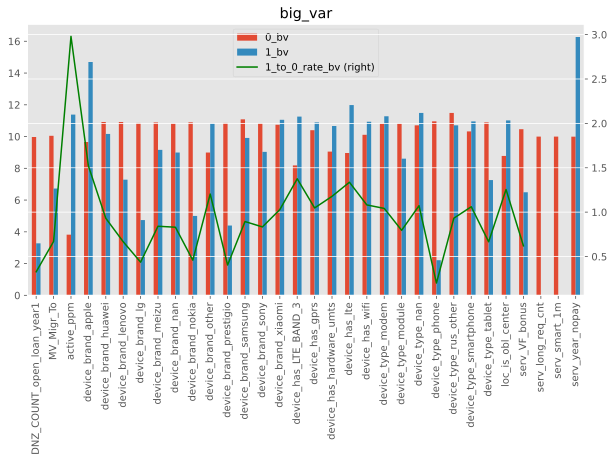

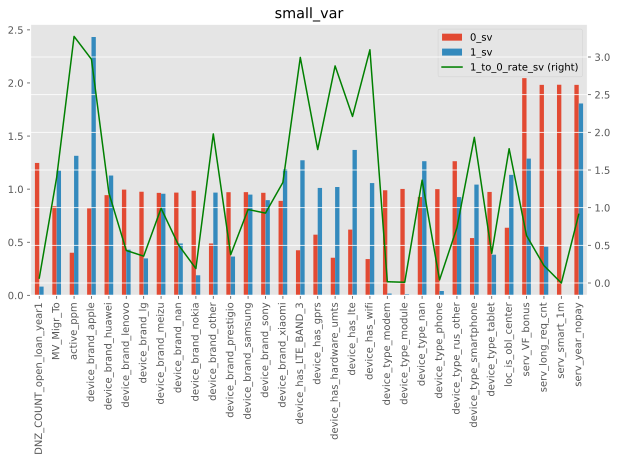

In [31]:
# VISUALZING TARGET DIFFERENCE RATE FOR CATEGORICAL COLUMNS

target_by_cat_cols = pd.DataFrame(index=cat_col_list, 
                                  columns=['0_bv', '1_bv', '1_to_0_rate_bv','0_sv', '1_sv', '1_to_0_rate_sv'])

for col in cat_col_list:
    temp = big_var_df_train.pivot_table(columns=col,values='target', aggfunc='median').fillna(0).applymap(float)
#     print(temp)
#     print(temp.values[0][1])
    target_by_cat_cols.loc[col]['0_bv'] = temp[0].values[0]
    try:
        target_by_cat_cols.loc[col]['1_bv'] = temp[1].values[0]
        target_by_cat_cols.loc[col]['1_to_0_rate_bv'] = temp[1].values[0]/temp[0].values[0]
    except:
        target_by_cat_cols.loc[col]['1_bv'] = np.nan
        target_by_cat_cols.loc[col]['1_to_0_rate_bv'] = np.nan
        
    temp = small_var_df_train.pivot_table(columns=col,values='target', aggfunc='median').fillna(0).applymap(float)
#     print(temp)
#     print(temp.values[0][1])
    target_by_cat_cols.loc[col]['0_sv'] = temp[0].values[0]
    try:
        target_by_cat_cols.loc[col]['1_sv'] = temp[1].values[0]
        target_by_cat_cols.loc[col]['1_to_0_rate_sv'] = temp[1].values[0]/temp[0].values[0]
    except:
        target_by_cat_cols.loc[col]['1_sv'] = np.nan
        target_by_cat_cols.loc[col]['1_to_0_rate_sv'] = np.nan


ax1 = target_by_cat_cols.sort_index().loc[:, ['0_bv', '1_bv']].plot(kind = 'bar',
                                                                       figsize = (10,5),
                                                                       rot = 90,
                                                                       sharex = True)


ax1 = target_by_cat_cols.sort_index()['1_to_0_rate_bv'].plot(secondary_y=True,
                                                                colormap = 'ocean',
                                                                rot = 90, 
                                                                legend = True,
                                                                sharex = True);

ax1.set_title('big_var')
    
ax2 = target_by_cat_cols.sort_index().loc[:, ['0_sv', '1_sv']].plot(kind = 'bar',
                                                                    figsize = (10,5),
                                                                    rot = 90,
                                                                    sharex = True);

ax2 = target_by_cat_cols.sort_index()['1_to_0_rate_sv'].plot(secondary_y=True,
                                                             colormap = 'ocean',
                                                             rot = 90,
                                                             legend = True,
                                                             sharex = True);

ax2.set_title('small_var')

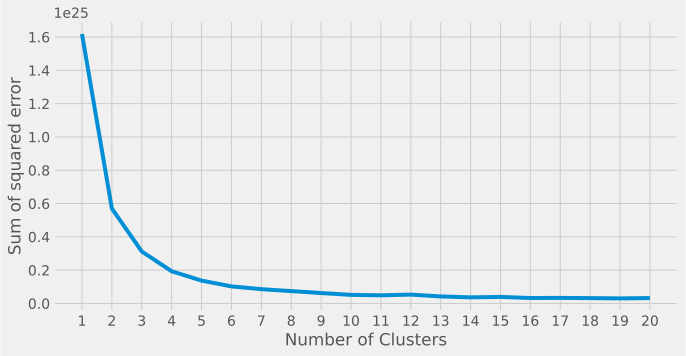

In [32]:
# from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

X_train_big_var = big_var_df_train.fillna(0)

plot_n_clusters = 20
sse = []
for k in range(1, plot_n_clusters+1):
    
        kmeans_batch = MiniBatchKMeans(n_clusters=k, 
                 init='k-means++', 
                 n_init=10, 
                 max_iter=300, 
                 random_state=1)
        
        kmeans_batch.fit(X_train_big_var)
        sse.append(kmeans_batch.inertia_)
        
plt.style.use("fivethirtyeight")
plt.plot(range(1, plot_n_clusters+1), sse)
plt.xticks(range(1, plot_n_clusters+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared error")
plt.show()

In [33]:
from sklearn.cluster import MiniBatchKMeans

X_train_big_var = big_var_df_train.fillna(0).astype('float32')
X_test_big_var = big_var_df_test.fillna(0).astype('float32')

kmeans_batch = MiniBatchKMeans(n_clusters=4, 
            init='k-means++', 
            n_init=10,
            max_iter=300, 
            tol=1e-04,
            random_state=1)


y_kmeans_batch_train = kmeans_batch.fit_predict(X_train_big_var)

y_kmeans_batch_test = kmeans_batch.predict(X_test_big_var)


big_var_df_train = big_var_df_train.assign(cluster = y_kmeans_batch_train)

big_var_df_test = big_var_df_test.assign(cluster = y_kmeans_batch_test)

In [34]:
# CHECKING MULTICOLLENEARITY IN DATA

def highlight_corr_06_plus(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_high = s >= 0.6
    return ['background-color: red' if v else '' for v in is_high]

collinear_cols_style = data_train_num_corr.loc[num_cols_to_use, num_cols_to_use].\
                                           style.apply(highlight_corr_06_plus).format("{:.2%}")


collinear_cols_style

,slope_traff,traff_m1,traff_m2,traff_m3,traff_m5,var_quant,dpi_duration,clc_no_vas_roam_std_mnt3,dpi_events,dpi_day_cnt,content_cnt_mea_mnt3,data_3g_tv_cnt_std_mnt1,all_cnt_mea_mnt3,all_clc_std_mnt3,MV_ARPU,dpi_download,dpi_upload,data_3g_tar_vol_std_mnt3,non_accum_internet_vol_std_mnt3,gprs_tar_vol_std_mnt3,MV_ap_4G_d,MV_ap_innet_out_v,MV_AP_total,MV_Traf_2G_d_Mb,MV_Traf_3G_d_Mb,MV_Traf_4G_d_Mb
index,,,,,,,,,,,,,,,,,,,,,,,,,,
slope_traff,100.00%,59.45%,40.79%,15.70%,-27.30%,17.46%,24.32%,5.78%,22.74%,7.47%,7.17%,11.86%,5.28%,5.87%,6.52%,40.81%,26.56%,10.70%,17.85%,10.78%,8.26%,-9.29%,7.52%,14.33%,13.41%,14.26%
traff_m1,59.45%,100.00%,84.77%,74.23%,59.68%,54.94%,50.95%,25.18%,49.18%,24.26%,23.76%,26.48%,20.97%,24.20%,21.89%,84.68%,57.69%,32.08%,48.13%,34.00%,30.83%,-29.74%,29.09%,36.67%,35.81%,35.85%
traff_m2,40.79%,84.77%,100.00%,84.65%,63.30%,57.10%,58.86%,26.10%,56.92%,28.82%,24.98%,24.74%,21.14%,25.04%,22.65%,99.75%,69.16%,33.82%,50.95%,35.73%,32.04%,-30.84%,30.26%,42.02%,40.86%,40.19%
traff_m3,15.70%,74.23%,84.65%,100.00%,66.20%,55.17%,51.22%,26.38%,49.14%,25.67%,24.28%,21.04%,21.30%,25.20%,20.98%,84.50%,58.92%,32.99%,49.07%,34.94%,31.01%,-30.28%,29.39%,37.20%,36.13%,36.14%
traff_m5,-27.30%,59.68%,63.30%,66.20%,100.00%,47.72%,37.67%,23.85%,37.30%,22.20%,21.00%,20.34%,19.38%,22.62%,19.87%,63.14%,44.30%,27.22%,39.13%,29.42%,29.01%,-26.46%,27.63%,30.36%,30.28%,29.15%
var_quant,17.46%,54.94%,57.10%,55.17%,47.72%,100.00%,41.00%,34.03%,40.18%,28.41%,35.76%,36.81%,31.51%,34.10%,27.91%,56.88%,40.87%,57.55%,83.02%,45.92%,42.67%,-43.57%,39.98%,45.54%,53.06%,45.59%
dpi_duration,24.32%,50.95%,58.86%,51.22%,37.67%,41.00%,100.00%,16.67%,74.28%,29.72%,20.39%,20.48%,19.71%,16.69%,14.94%,58.18%,46.89%,23.21%,34.93%,30.14%,23.74%,-23.80%,22.43%,33.63%,29.80%,21.82%
clc_no_vas_roam_std_mnt3,5.78%,25.18%,26.10%,26.38%,23.85%,34.03%,16.67%,100.00%,18.97%,23.84%,21.18%,26.43%,33.72%,89.11%,78.20%,25.88%,19.66%,27.85%,35.78%,28.91%,76.47%,-15.77%,77.74%,23.98%,29.22%,16.27%
dpi_events,22.74%,49.18%,56.92%,49.14%,37.30%,40.18%,74.28%,18.97%,100.00%,32.47%,17.07%,22.35%,22.92%,18.63%,17.38%,56.20%,45.72%,23.80%,34.41%,29.89%,23.70%,-24.88%,22.30%,34.64%,31.61%,23.85%


In [35]:
data_train_num_corr.loc[num_cols_to_use, num_cols_to_use]['dpi_duration'].sort_values()

index
MV_ap_innet_out_v                 -0.237964
MV_ARPU                            0.149362
clc_no_vas_roam_std_mnt3           0.166665
all_clc_std_mnt3                   0.166857
all_cnt_mea_mnt3                   0.197124
content_cnt_mea_mnt3               0.203886
data_3g_tv_cnt_std_mnt1            0.204845
MV_Traf_4G_d_Mb                    0.218160
MV_AP_total                        0.224289
data_3g_tar_vol_std_mnt3           0.232086
MV_ap_4G_d                         0.237377
slope_traff                        0.243220
dpi_day_cnt                        0.297242
MV_Traf_3G_d_Mb                    0.297971
gprs_tar_vol_std_mnt3              0.301408
MV_Traf_2G_d_Mb                    0.336311
non_accum_internet_vol_std_mnt3    0.349259
traff_m5                           0.376725
var_quant                          0.410000
dpi_upload                         0.468882
traff_m1                           0.509538
traff_m3                           0.512153
dpi_download              

In [36]:
data_train_num_corr.loc[num_cols_to_use, num_cols_to_use]['MV_ARPU'].sort_values()

index
MV_ap_innet_out_v                 -0.040133
slope_traff                        0.065202
MV_Traf_4G_d_Mb                    0.143002
dpi_duration                       0.149362
dpi_events                         0.173823
dpi_upload                         0.175154
traff_m5                           0.198679
traff_m3                           0.209790
content_cnt_mea_mnt3               0.210554
traff_m1                           0.218905
dpi_download                       0.224085
traff_m2                           0.226468
MV_Traf_2G_d_Mb                    0.230180
data_3g_tar_vol_std_mnt3           0.240188
dpi_day_cnt                        0.244270
data_3g_tv_cnt_std_mnt1            0.269210
MV_Traf_3G_d_Mb                    0.276613
gprs_tar_vol_std_mnt3              0.277174
var_quant                          0.279131
non_accum_internet_vol_std_mnt3    0.305539
all_cnt_mea_mnt3                   0.331284
clc_no_vas_roam_std_mnt3           0.782043
all_clc_std_mnt3          

In [37]:
totals_for_pca = ['MV_ARPU', 'MV_ap_4G_d', 'MV_AP_total','all_clc_std_mnt3', 'clc_no_vas_roam_std_mnt3']
dpi_for_pca = ['dpi_duration', 'dpi_upload', 'dpi_download', 'dpi_events']

In [38]:
traffic_cols.sort()
traffic_cols_plus_target = ['traff_m5', 'traff_m3','traff_m2','traff_m1', 'target']
traffic_cols_plus_target.sort()

In [39]:
# DIMETIONALITY REDUCTION BY PCA FOR MULTICOLLINEAR COLUMNS

data_train_num_filtered = data_train_num_filtered.fillna(0)
data_test_num_filtered = data_test_num_filtered.fillna(0)


In [40]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[totals_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[totals_for_pca])

pca_train = PCA(random_state=3)
pca_test = PCA(random_state=3)

X_train_pca_totals = pca_train.fit_transform(X_train_std)
X_test_pca_totals = pca_test.fit_transform(X_train_std)

pd.DataFrame(pca_train.explained_variance_ratio_).style.format("{:.2%}")


,0
0,82.47%
1,11.53%
2,4.10%
3,1.85%
4,0.05%


In [41]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[dpi_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[dpi_for_pca])

pca_train = PCA(random_state=3)
pca_test = PCA(random_state=3)

X_train_pca_dpi = pca_train.fit_transform(X_train_std)
X_test_pca_dpi = pca_test.fit_transform(X_train_std)

pd.DataFrame(pca_train.explained_variance_ratio_).style.format("{:.2%}")

,0
0,68.30%
1,16.84%
2,8.45%
3,6.40%


In [42]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[totals_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[totals_for_pca])

pca_train = PCA(n_components = 1, random_state=3)
pca_test = PCA(n_components = 1, random_state=3)

X_train_pca_totals = pca_train.fit_transform(X_train_std)
X_test_pca_totals = pca_test.fit_transform(X_test_std)



sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[dpi_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[dpi_for_pca])

pca_train = PCA(n_components = 2, random_state=3)
pca_test = PCA(n_components = 2, random_state=3)

X_train_pca_dpi = pca_train.fit_transform(X_train_std)
X_test_pca_dpi = pca_test.fit_transform(X_test_std)


del(X_train_std, X_test_std)

In [43]:
# PREPARING DATA FOR MODELS

data_train_model = data_train_num_filtered.drop(totals_for_pca, axis=1).fillna(0)
data_train_model = data_train_model.drop(dpi_for_pca, axis=1)
data_train_model = data_train_model.assign(pca1=X_train_pca_totals[:, 0],
                                           pca2=X_train_pca_dpi[:, 0],
                                           pca3=X_train_pca_dpi[:, 1])

data_train_model_varQ90 = data_train_model[data_train_model['var_quant'] >= 8]
data_train_model_varQ90 = data_train_model_varQ90.merge(big_var_df_train['cluster'], how='left',
                                                       left_index = True, right_index = True)

data_train_model_full = data_train_model
data_train_model = data_train_model[~data_train_model['var_quant'].isin([8,9])]

data_train_model_varQ90 = data_train_model_varQ90.fillna(0)

In [44]:
data_test_model = data_test_num_filtered.drop(totals_for_pca, axis=1).fillna(0)
data_test_model = data_test_model.drop(dpi_for_pca, axis=1)
data_test_model = data_test_model.assign(pca1=X_test_pca_totals[:, 0],
                                         pca2=X_test_pca_dpi[:, 0],
                                         pca3=X_test_pca_dpi[:, 1])

data_test_model_varQ90 = data_test_model[data_test_model['var_quant'] >= 8]
data_test_model_varQ90 = data_test_model_varQ90.merge(big_var_df_train['cluster'], how='left',
                                                      left_index = True, right_index = True)

data_test_model_full = data_test_model
data_test_model = data_test_model[~data_test_model['var_quant'].isin([8,9])]

data_test_model_varQ90 = data_test_model_varQ90.fillna(0)

In [45]:
data_train_model.columns

Index(['slope_traff', 'traff_m1', 'traff_m2', 'traff_m3', 'traff_m5',
       'var_quant', 'dpi_day_cnt', 'content_cnt_mea_mnt3',
       'data_3g_tv_cnt_std_mnt1', 'all_cnt_mea_mnt3',
       'data_3g_tar_vol_std_mnt3', 'non_accum_internet_vol_std_mnt3',
       'gprs_tar_vol_std_mnt3', 'MV_ap_innet_out_v', 'MV_Traf_2G_d_Mb',
       'MV_Traf_3G_d_Mb', 'MV_Traf_4G_d_Mb', 'target', 'pca1', 'pca2', 'pca3'],
      dtype='object')

In [46]:
def df_normalization(df, cols_to_exclude = []):
    
    
    cols_to_use = list(df.columns)
   
    for col in cols_to_exclude:
        cols_to_use.remove(col)
        
    df_norm = df.copy()
    
    for column in cols_to_use: 
        df_norm[column] = (df_norm[column] - df_norm[column].min()) /(df_norm[column].max() - df_norm[column].min()) 

    return df_norm

In [47]:
X, y = data_train_model.loc[:, data_train_model.columns != 'target'], data_train_model.target

X = df_normalization(X, ['var_quant'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 17)

X_full, y_full = data_test_model_full.loc[:, data_test_model_full.columns != 'target'], data_test_model_full.target

X_full = df_normalization(X_full, ['var_quant'])

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.30, random_state = 17)

X_varQ90 = data_train_model_varQ90.loc[:, data_train_model_varQ90.columns != 'target']
y_varQ90 = data_train_model_varQ90.target

X_varQ90 = df_normalization(X_varQ90, ['var_quant'])

X_train_varQ90, X_test_varQ90, y_train_varQ90, y_test_varQ90 = train_test_split(X_varQ90, y_varQ90, 
                                                                                test_size=0.30, random_state = 17)


In [48]:
X_test_test, y_test_test = data_test_model.loc[:, data_test_model.columns != 'target'], data_test_model.target
X_test_test = df_normalization(X_test_test, ['var_quant'])

X_test_test_full = data_test_model_full.loc[:, data_test_model_full.columns != 'target']
X_test_test_full = df_normalization(X_test_test_full, ['var_quant'])
y_test_test_full = data_test_model_full.target

X_test_test_varQ90 = data_test_model_varQ90.loc[:, data_test_model_varQ90.columns != 'target']
X_test_test_varQ90 = df_normalization(X_test_test_varQ90, ['var_quant'])
y_test__test_varQ90 = data_test_model_varQ90.target


In [49]:
data_test_model_varQ90.columns

Index(['slope_traff', 'traff_m1', 'traff_m2', 'traff_m3', 'traff_m5',
       'var_quant', 'dpi_day_cnt', 'content_cnt_mea_mnt3',
       'data_3g_tv_cnt_std_mnt1', 'all_cnt_mea_mnt3',
       'data_3g_tar_vol_std_mnt3', 'non_accum_internet_vol_std_mnt3',
       'gprs_tar_vol_std_mnt3', 'MV_ap_innet_out_v', 'MV_Traf_2G_d_Mb',
       'MV_Traf_3G_d_Mb', 'MV_Traf_4G_d_Mb', 'target', 'pca1', 'pca2', 'pca3',
       'cluster'],
      dtype='object')

### MODELS

In [50]:
# LINEAR REGRESSION RESULTS


# cols_traff_only = ['traff_m5', 'traff_m4', 'traff_m3', 'traff_m2', 'traff_m1']

# Train set results
# RMSE train: 8.863683, test: 8.775289
# R^2 train: 0.420902, test: 0.428726

# Test set results
# RMSE test_test: 8.837257
# R^2 test_test: 0.423239

#ALL DATA NORMALIZED  - BETTER RESULTS, columns = chosen by best target correlation + var_quantiles + slope + cluster

# FULL DATASET

# Train set results
# RMSE train: 8.749031, test: 8.664875
# R^2 train: 0.435786, test: 0.443012

# Test set results
# RMSE test_test: 8.723869
# R^2 test_test: 0.437945

# DIFF MODEL BY QUANTILE 
# Train set results
# RMSE train TOTAL: 8.503218, test TOTAL: 8.422132
# R^2 train TOTAL: 0.486569, test TOTAL: 0.498329

# Test set results
# RMSE test test TOTAL: 8.730296
# R^2 test test TOTAL: 0.437116



In [51]:
# FULL DATA SET

slr = LinearRegression(normalize=True)

slr.fit(X_train_full, y_train_full)

y_train_pred = slr.predict(X_train_full)
y_test_pred = slr.predict(X_test_full)

print()
print('Train set results')
print()
print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))



y_test_test_pred = slr.predict(X_test_test_full)

print()
print('Test set results')
print()
print('RMSE test_test: {:.6f}'.format(
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 test_test: {:.6f}'.format(
        r2_score(y_test_test_full, y_test_test_pred)))


Train set results

RMSE train: 8.749127, test: 8.664712
R^2 train: 0.435774, test: 0.443033

Test set results

RMSE test_test: 8.723888
R^2 test_test: 0.437942


In [52]:
import os
cwd = os.getcwd()

In [53]:
cwd

'C:\\Users\\Edward\\Documents\\Appleolga\\Final_pro\\Final_project'

In [54]:
#DIFFERENT MODELS BY VAR_QUANT

X_list, y_list = [], []
df_list = []

coeff = []

for g, v in data_train_model.groupby('var_quant'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    
#Adding data with 90th qauntile by traffic variance

X_list.append(data_train_model_varQ90.loc[:, data_train_model_varQ90.columns != 'target'])
y_list.append(data_train_model_varQ90.target)  


for i, j in zip(X_list, y_list):
    df_list.append(train_test_split(i, j, test_size=0.30, train_size = 0.70, random_state = 13))
    

y_train_pred, y_test_pred, y_train, y_test = pd.Series(), pd.Series(), pd.Series(), pd.Series()

for X_tr, X_ts, y_tr, y_ts in df_list:
    slr = LinearRegression(normalize=True)

    slr.fit(X_tr, y_tr)
    train_pred = pd.Series(data = slr.predict(X_tr), index=y_tr.index)
    y_train_pred = y_train_pred.append(train_pred)
#     print(y_train_pred.shape)
    
    test_pred = pd.Series(data = slr.predict(X_ts), index=y_ts.index)
    y_test_pred = y_test_pred.append(test_pred)
    
    y_train = y_train.append(y_tr)
    y_test = y_test.append(y_ts) 
    
    print(str(X_tr['var_quant'].unique()[0])+' quantile set results')
    print()

    print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_tr, train_pred, squared = False),
        mean_squared_error(y_ts, test_pred, squared = False)))
    print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_tr, train_pred),
        r2_score(y_ts, test_pred)))
    print()
    
    coeff.append(slr.coef_)    
    
    joblib_file = "joblib_model"+"_q"+str(int(X_tr['var_quant'].unique()[0]))+".pkl"
    joblib.dump(slr, joblib_file)

print('RMSE train TOTAL: {:.6f}, test TOTAL: {:.6f}'.format(
mean_squared_error(y_train, y_train_pred, squared = False),
mean_squared_error(y_test, y_test_pred, squared = False)))  

print('R^2 train TOTAL: {:.6f}, test TOTAL: {:.6f}'.format(
        r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))
        

0 quantile set results

RMSE train: 1.750945, test: 1.882155
R^2 train: 0.021417, test: 0.014546

1 quantile set results

RMSE train: 2.016239, test: 1.818295
R^2 train: 0.076439, test: 0.091739

2 quantile set results

RMSE train: 2.681672, test: 2.403926
R^2 train: 0.175120, test: 0.104182

3 quantile set results

RMSE train: 2.719173, test: 3.194064
R^2 train: 0.234533, test: 0.196777

4 quantile set results

RMSE train: 3.749181, test: 3.618983
R^2 train: 0.230251, test: 0.252339

5 quantile set results

RMSE train: 4.783066, test: 4.795902
R^2 train: 0.285120, test: 0.290734

6 quantile set results

RMSE train: 6.220195, test: 5.801483
R^2 train: 0.321524, test: 0.329881

7 quantile set results

RMSE train: 8.230926, test: 8.386286
R^2 train: 0.353994, test: 0.363293

9 quantile set results

RMSE train: 16.617414, test: 16.446298
R^2 train: 0.320587, test: 0.339508

RMSE train TOTAL: 8.469787, test TOTAL: 8.389730
R^2 train TOTAL: 0.490598, test TOTAL: 0.502182


In [55]:
#DIFFERENT MODELS BY VAR_QUANT TEST_TEST SET

X_list, y_list = [], []
df_list = []


for g, v in data_test_model.groupby('var_quant'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    
X_list.append(data_test_model_varQ90.loc[:, data_test_model_varQ90.columns != 'target'])
y_list.append(data_test_model_varQ90.target) 
    
for i, j in zip(X_list, y_list):
    df_list.append([i,j])
    
y_test_test_pred, y_test_test = pd.Series(), pd.Series()

for X_ts, y_ts in df_list:
    
    joblib_file = "joblib_model"+"_q"+str(X_ts['var_quant'].unique()[0])+".pkl"
    try: 
        slr = joblib.load(joblib_file)
    except:
        joblib_file = "joblib_model"+"_q"+str(X_ts['var_quant'].unique()[0]+1)+".pkl"
        slr = joblib.load(joblib_file)

    test_test_pred = pd.Series(data = slr.predict(X_ts), index=y_ts.index)
    y_test_test_pred = y_test_test_pred.append(test_test_pred)
    
    print()
    print(str(X_ts['var_quant'].unique()[0])+' quantile set results')
    print()

    print('RMSE test test: {:.6f}'.format(
        mean_squared_error(y_ts, test_test_pred, squared = False)))
    print('R^2 test test: {:.6f}'.format(
        r2_score(y_ts, test_test_pred)))
   
    y_test_test = y_test_test.append(y_ts) 
   
print()
print('RMSE test test TOTAL: {:.6f}'.format(mean_squared_error(y_test_test, y_test_test_pred, squared = False)))
print('R^2 test test TOTAL: {:.6f}'.format(r2_score(y_test_test, y_test_test_pred)))
    
   


0 quantile set results

RMSE test test: 2.421935
R^2 test test: -1.027522

1 quantile set results

RMSE test test: 2.150538
R^2 test test: 0.067572

2 quantile set results

RMSE test test: 2.501966
R^2 test test: 0.041720

3 quantile set results

RMSE test test: 3.369535
R^2 test test: 0.168994

4 quantile set results

RMSE test test: 4.350359
R^2 test test: 0.202090

5 quantile set results

RMSE test test: 5.032434
R^2 test test: 0.265178

6 quantile set results

RMSE test test: 6.527612
R^2 test test: 0.287715

7 quantile set results

RMSE test test: 9.072313
R^2 test test: 0.298802

8 quantile set results

RMSE test test: 16.789040
R^2 test test: 0.262160

RMSE test test TOTAL: 8.723639
R^2 test test TOTAL: 0.437975


In [ ]:
# LASSO RESULTS

#

In [56]:
sc_y = StandardScaler()
sc_x = StandardScaler()


X_train_std = sc_x.fit_transform(X_train_full)
X_test_std = sc_x.transform(X_test_full)
X_test_test_std = sc_x.transform(X_test_test_full)
y_train_std = sc_y.fit_transform(y_train_full[:, np.newaxis]).flatten()

In [57]:
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train_std,y_train_std)
y_train_pred_std = lasso.predict(X_train_std)
y_test_pred_std = lasso.predict(X_test_std)
y_test_test_pred_std = lasso.predict(X_test_test_std)

print('RMSE train: {:.6f}, test: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train_full, sc_y.inverse_transform(y_train_pred_std), squared = False),
        mean_squared_error(y_test_full, sc_y.inverse_transform(y_test_pred_std), squared = False), 
        mean_squared_error(y_test_test_full, sc_y.inverse_transform(y_test_test_pred_std), squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train_full, sc_y.inverse_transform(y_train_pred_std)),
        r2_score(y_test_full, sc_y.inverse_transform(y_test_pred_std)),
        r2_score(y_test_test_full, sc_y.inverse_transform(y_test_test_pred_std))))

RMSE train: 8.749184, test: 8.665191, test_test: 8.724071
R^2 train: 0.435766, test: 0.442971, test_test:0.437919


In [58]:
# LGBM REGRESSOR RESULTS


#ALL DATA NORMALIZED  - BETTER RESULTS, columns = chosen by best target correlation + var_quantiles + slope + cluster

# FULL DATASET

# RMSE train: 7.973927, test: 8.563232, test_test: 8.155191
# R^2 train: 0.531328, test: 0.456003, test_test:0.508833

# Test set results


# DIFF MODEL BY QUANTILE 
# Train set results


# Test set results




##hight corr target columns, stats chosen by highest correlation with target + pcas + var quant


#'traff_m1', 'traff_m2', 'traff_m3', 'traff_m5', 'var_quant','dpi_day_cnt', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt1',
# 'all_cnt_mea_mnt3', 'all_clc_std_mnt3', 'data_3g_tar_vol_std_mnt3','non_accum_internet_vol_std_mnt3', 'gprs_tar_vol_std_mnt3',
# 'MV_ap_innet_out_v', 'MV_Traf_2G_d_Mb', 'MV_Traf_3G_d_Mb','MV_Traf_4G_d_Mb', 'pca1', 'pca2', 'pca3'

# FULL DATASET

# RMSE train: 7.985060, test: 8.567211, test_test: 8.164066 
# R^2 train: 0.530019, test: 0.455497, test_test:0.507764

# FULL DATASET NORMALIZED DATA

# RMSE train: 7.977355, test: 8.551193, test_test: 8.153748 
# R^2 train: 0.530926, test: 0.457531, test_test:0.509007

# model = ltb.LGBMRegressor(learning_rate = 0.15, 
#                           n_estimators =300, 
#                           reg_alpha = 0.05 ,
#                           objective ='regression',
#                           random_state = 0)


# RMSE train: 6.895497, test: 8.698676, test_test: 7.482220 !!!!!!!!!!!!!
# R^2 train: 0.649527, test: 0.438658, test_test:0.586551








# split by var_quant < 8 and var_quant  8 and 9 + cat_cols for q8 and q9 

# TEST DATA RESULT

# var_q_less_than_8 set results

# RMSE test: 4.919048
# R^2 test: 0.387249
# RMSE test TOTAL: 4.919048

# var_q_8_and_9 set results

# RMSE test: 16.737090
# R^2 test: 0.266719
# RMSE test TOTAL: 8.682401

# RMSE test TOTAL: 8.682401 !!!
# R^2 test TOTAL: 0.443276

# split by var_quant < 8 and var_quant  8 and 9 WITHOUT cat_cols for q8 and q9 

# var_q_less_than_8 set results

# RMSE test: 4.919048
# R^2 test: 0.387249
# RMSE test TOTAL: 4.919048

# var_q_8_and_9 set results

# RMSE test: 16.833100
# R^2 test: 0.258282
# RMSE test TOTAL: 8.719444

# RMSE test TOTAL: 8.719444
# R^2 test TOTAL: 0.438515




In [59]:
X_train_full = X_train_full.drop('var_quant', axis = 1)
X_test_full = X_test_full.drop('var_quant', axis = 1)
X_test_test_full = X_test_test_full.drop('var_quant', axis = 1)

In [60]:
model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train_full,y_train_full)
y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)
y_test_test_pred = model.predict(X_test_test_full)

print('RMSE train: {:.6f}, test: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False), 
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred),
        r2_score(y_test_test_full, y_test_test_pred)))



RMSE train: 7.973078, test: 8.583594, test_test: 8.161030
R^2 train: 0.531428, test: 0.453413, test_test:0.508130


In [61]:
n_folds = 5

from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

scoring = make_scorer(mean_squared_error, squared = False,greater_is_better=False)

kf = KFold(n_folds, shuffle=True, random_state=42)

parameters = {'learning_rate': [0.05, 0.15, 0.20],
              'n_estimators': [100, 200, 300, 400],
              'reg_alpha':[0.05, 0.7, 0.8]}


lgbm = LGBMRegressor(silent=True, random_state= 3)

grid_search = GridSearchCV(lgbm, parameters, scoring=scoring, n_jobs=-1, cv=kf, verbose = True)
res = grid_search.fit(X_train_full, y_train_full)


res


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.4min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMRegressor(random_state=3), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.15, 0.2],
                         'n_estimators': [100, 200, 300, 400],
                         'reg_alpha': [0.05, 0.7, 0.8]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=True)

In [62]:
print(f'Best score: {grid_search.best_score_}', '\n') 
print('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}:  {best_parameters[param_name]}')

Best score: -8.631982806291463 

Best parameters set:
	learning_rate:  0.05
	n_estimators:  100
	reg_alpha:  0.7


In [63]:
grid_search.cv_results_.get('mean_test_score')

array([-8.6327731 , -8.63198281, -8.63270399, -8.64424531, -8.64550356,
       -8.64532301, -8.66250492, -8.66313602, -8.66240314, -8.67754252,
       -8.67776355, -8.67904085, -8.69529672, -8.69992871, -8.70399582,
       -8.7592605 , -8.76771686, -8.76915057, -8.80893698, -8.81450757,
       -8.80732894, -8.8471504 , -8.84942901, -8.84119741, -8.73732341,
       -8.73390051, -8.73073792, -8.81451434, -8.81637186, -8.82680234,
       -8.8762399 , -8.87775397, -8.88306826, -8.91442598, -8.91478898,
       -8.93096254])

In [64]:
grid_search.cv_results_.get('params')[35]

{'learning_rate': 0.2, 'n_estimators': 400, 'reg_alpha': 0.8}

In [65]:
model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0,
                          learning_rate = 0.2,
                          n_estimators = 400, 
                          reg_alpha = 0.08)


model.fit(X_train_full,y_train_full)
y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)
y_test_test_pred = model.predict(X_test_test_full)

print('RMSE train: {:.6f}, test: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False), 
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred),
        r2_score(y_test_test_full, y_test_test_pred)))



RMSE train: 6.170960, test: 8.848464, test_test: 7.081323
R^2 train: 0.719308, test: 0.419159, test_test:0.629669
